# ImageNet ResNet-50 plots

In this notebok, we perform hyperparameter optimization for the logit normalization.

Update the following variables with values corresponding to your own experiments:

In [19]:
# Paths
MODEL_CE_PATH = "../experiments/classification/imagenet/logs/resnet50/version_0/checkpoints/last.ckpt"
MODEL_LS_PATH = "../experiments/classification/imagenet/logs/resnet50_ls/version_1/checkpoints/last.ckpt" #LS 0.2

# Choose your device

DEVICE = "cuda:0"  # or "cpu"

# Whether to save the image or not

SAVE_IMG = False

Prepare the datamodule and disable gradients:

In [20]:
import torch
from torch_uncertainty.datamodules import ImageNetDataModule

# Disable gradients globally
torch.set_grad_enabled(False)

dm = ImageNetDataModule("./data/imagenet1k", batch_size=256, num_workers=8, interpolation="bicubic")
dm.prepare_data()
dm.setup("test")

Instantiate the models in memory

In [21]:
import torch
from torch_uncertainty.models.resnet.std import resnet
from torch_uncertainty.datamodules import ImageNetDataModule

model = resnet(arch=50, in_channels=3, conv_bias=False, num_classes=1000)
sd = torch.load(MODEL_CE_PATH)["state_dict"]
sd = {k.replace("model.", ""): v for k, v in sd.items()}
model.load_state_dict(sd)
model = model.to(DEVICE)
model = model.eval()

model_ls = resnet(arch=50, in_channels=3, conv_bias=False, num_classes=1000)
sd = torch.load(MODEL_LS_PATH)["state_dict"]
sd = {k.replace("model.", ""): v for k, v in sd.items()}
model_ls.load_state_dict(sd)
model_ls = model_ls.to(DEVICE)
model_ls = model_ls.eval()

/tmp/ipykernel_1332633/201742749.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(MODEL_CE_PATH)["state_dict"]
/tmp/ipykernel_1332633/201742749.py:13: Fut

Compute the logits with the CE-based and LS-based models. This may take a few minutes.

In [22]:
from tqdm.auto import tqdm
from torch_uncertainty_ls.utils import norm_logits

scores = []
scores_ls = []
correct_samples = []
correct_samples_ls = []
logits = []
logits_ls = []
targets = []

for batch in tqdm(dm.test_dataloader()[0]):
    x, y = batch
    x = x.to(DEVICE)
    logit = model(x).cpu()
    logits.append(logit)

    y_pred = logit.softmax(dim=-1)
    scores.append(y_pred)
    correct_samples.append(y_pred.argmax(-1) == y)

    logit_ls = model_ls(x).cpu()
    logits_ls.append(logit_ls)

    y_pred_ls = logit_ls.softmax(dim=-1)
    scores_ls.append(y_pred_ls)
    correct_samples_ls.append(y_pred_ls.argmax(-1) == y)

    targets.append(y)

scores = torch.cat(scores)
scores_ls = torch.cat(scores_ls)
correct_samples = torch.cat(correct_samples)
correct_samples_ls = torch.cat(correct_samples_ls)
logits = torch.cat(logits)
logits_ls = torch.cat(logits_ls)
targets = torch.cat(targets)


  0%|          | 0/196 [00:00<?, ?it/s]

100%|██████████| 196/196 [01:48<00:00,  1.81it/s]


In [23]:
from torch_uncertainty_ls.utils import risk_coverage_curve

ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples, scores.max(1).values)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls, scores_ls.max(1).values)

Create the plots

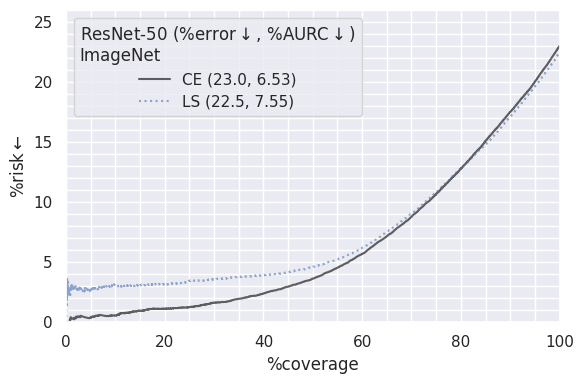

In [24]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk,ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="ResNet-50 (%error$\downarrow$, %AURC$\downarrow$)\nImageNet", loc="upper left")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 26)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("imagenet.pdf", dpi=300)

plt.show();

### Logits normalization plots with hyperparameter optimization on a holdout validation set

In [25]:
import torch

torch.manual_seed(0)
idx = torch.randperm(len(logits))
val_idx = idx[:10000]
test_idx = idx[10000:]

Optimize the logit normalization hyperparameters

In [26]:
def search_p(logits: torch.Tensor, labels: torch.Tensor):
    # grid search for best temperature
    # objective is AURC not NLL
    ps = [1,2,3,4,5,6,7,8, 9, 10]
    best_aurc = 1.0
    best_p = None
    best_aurcs = []

    correct_idx = (logits.argmax(dim=-1) == labels)
    for p in ps:
        msp_scaled = norm_logits(
            logits.T, p=p, add_unit="mean"
        ).T.max(dim=-1).values
        risk_scaled, cov_scaled,_ = risk_coverage_curve(
            correct_idx, msp_scaled
        )
        aurc = torch.trapz(risk_scaled, cov_scaled)
        if aurc < best_aurc:
            best_aurc = aurc
            best_risk = risk_scaled
            best_coverage = cov_scaled
            best_p = p

        best_aurcs.append(aurc.item())

    return best_p, best_aurcs

In [27]:
ce_p, best_aurcs_val = search_p(
    logits[val_idx], targets[val_idx]
)

print(f"CE - best normalization normalization: {ce_p}")
print(f"AURCs: {[round(val, 3) for val in best_aurcs_val]}")

ls2_p, best_aurcs_val = search_p(
    logits_ls[val_idx], targets[val_idx]
)
print(f"LS - best normalization normalization: {ls2_p}")
print(f"AURCs: {[round(val, 3) for val in best_aurcs_val]}")

CE - best normalization normalization: 8
AURCs: [0.106, 0.097, 0.083, 0.073, 0.067, 0.065, 0.064, 0.064, 0.064, 0.064]
LS - best normalization normalization: 5
AURCs: [0.097, 0.078, 0.065, 0.061, 0.06, 0.06, 0.06, 0.061, 0.061, 0.062]


In [28]:
normalized_scores = norm_logits(logits[test_idx].T, p=ce_p).T
normalized_scores_ls = norm_logits(logits_ls[test_idx].T, p=ls2_p).T

Compute the coverages and the risks

In [29]:
from torch_uncertainty_ls.utils import risk_coverage_curve

ce_risk, ce_cov, thresholds = risk_coverage_curve(correct_samples[test_idx], normalized_scores.max(1).values)
ls_risk, ls_cov, thresholds_ls = risk_coverage_curve(correct_samples_ls[test_idx], normalized_scores_ls.max(1).values)

Make the plot

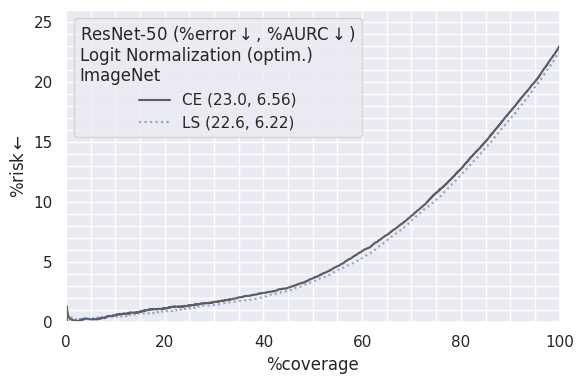

In [30]:
import matplotlib.pyplot as plt
import seaborn

# set the style
seaborn.set_theme()

# Compute and show the risk-coverage curves
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(
    ce_cov * 100,
    ce_risk * 100,
    label=f"CE ({ce_risk[-1]*100:.1f}, {torch.trapz(ce_risk,ce_cov).item()*100:.2f})",
    alpha=0.6,
    color="black",
)
ax.plot(
    ls_cov * 100,
    ls_risk * 100,
    label=f"LS ({ls_risk[-1]*100:.1f}, {torch.trapz(ls_risk, ls_cov).item()*100:.2f})",
    alpha=0.6,
    linestyle="dotted",
)
ax.set_xlabel("%coverage")
ax.set_ylabel("%risk$\leftarrow$")
ax.legend(title="ResNet-50 (%error$\downarrow$, %AURC$\downarrow$)\nLogit Normalization (optim.)\nImageNet", loc="upper left")
ax.grid(visible=True, which="both")
ax.set_xlim(0, 100)
ax.set_ylim(0, 26)
ax.minorticks_on()
fig.tight_layout()

if SAVE_IMG:
    plt.savefig("imagenet_norm.pdf", dpi=300)

plt.show();